## Logistic regression

We want to minimize
$$\min_{x\in {\mathbb R}^{d}} f(x)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(a_i^\top x)) + (1 - y_i) \log (1 - s(a_i^\top x))\right) + \frac{\gamma}{2}\|x\|^2,$$
where  $a_i\in {\mathbb R}^{d}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ is the sigmoid function.
The gradient is given by $\nabla f(x) = \frac{1}{n}\sum_{i=1}^n a_i(s(a_i^\top x)-y_i) + \gamma x$.

This is a smooth function with smoothness constant $L=\frac{1}{4}\lambda_{\max}(A^\top A) + \gamma$, where $\lambda_{\max}$ denotes the largest eigenvalue.

For this experiment we used mushrooms and covtype datasets from the [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) library. Since the former is smaller and hence runs faster, we use it below.

In [1]:
import matplotlib
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

from optimizers import Adgd, AdgdAccel, Armijo, NestLine
from loss_functions import logistic_loss, logistic_gradient

sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
dataset = 'w8a'
data_path = './datasets/' + dataset
if dataset == 'covtype':
    data_path += '.bz2'

if dataset == 'covtype':
    it_max = 10000
elif dataset == 'w8a':
    it_max = 8000
else:
    it_max = 3000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))


data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
if (np.unique(y) == [-1, 1]).all():
    y = (y+1) / 2
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / n if dataset == 'covtype' else L / (10 * n) 
w0 = np.zeros(d)

def loss_func(w):
    return logistic_loss(w, X, y, l2)

def grad_func(w):
    return logistic_gradient(w, X, y, l2)

In [2]:
ar = Armijo(lr0=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ar.run(w0=w0)

In [3]:
nest_ls = NestLine(lr0=1 / L, mu=0, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest_ls.run(w0=w0)

In [4]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

In [5]:
ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)

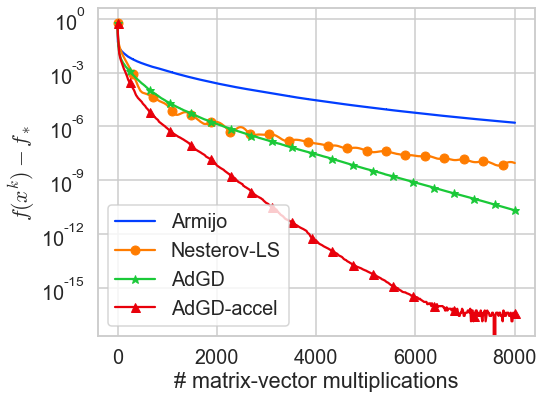

In [6]:
optimizers = [ar, nest_ls, adgd, ad_acc]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
labels = ['Armijo', 'Nesterov-LS', 'AdGD', 'AdGD-accel']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('# matrix-vector multiplications')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()